In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import MDAnalysis as mda
from MDAnalysis.coordinates.memory import MemoryReader
from MDAnalysis.analysis.base import AnalysisFromFunction
from MDAnalysis.analysis import align
import MDAnalysis.analysis.encore as encore
import subprocess

import nglview

from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf
from progressbar import *

from MDAnalysis.analysis.rms import rmsd
import random

%matplotlib inline

/home/kam1m17/anaconda2/lib/python2.7/site-packages/MDAnalysis/due.py:88: UserWarning: No module named duecredit
  warnings.warn(str(err))
/home/kam1m17/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def rmsd_vs_time_MDanalysis(u, reference):
    
    #u = mda.Universe(top, traj)
    ref = mda.Universe(reference)

    u.trajectory[0]

    nframes = len(u.trajectory)

    results = np.zeros((nframes, 2 ), dtype=np.float64)
    
    
    #Performing rmsd calculation for input trajectory file
    
    pos = u.select_atoms("name CA")
    
    widgets = ['Calculating RMSD vs time: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA(), ' ', FileTransferSpeed()] #see docs for other options

    pbar = ProgressBar(widgets=widgets, maxval=nframes)
    pbar.start()
    
    for iframe, ts in enumerate(u.trajectory):                             
        
        results[iframe, :] = (u.trajectory.time, rmsd(pos.positions, ref.select_atoms("name CA").positions - ref.select_atoms("name CA").center_of_mass()
                                                  , center=True, superposition=True))
        
        pbar.update(iframe)
    
    pbar.finish()
    print
    
    time = np.trim_zeros(results[:,0], 'b')
    results_trimmed = np.trim_zeros(results[:,1])

    result = np.column_stack((time,results_trimmed))
    
    #Statistical properties of the RMSD vs time graph obtained
    
    angstrom = u'\u212B'.encode('utf-8')
    
    av_rmsd = np.mean(result[:,1])

    min_rmsd = [ int(result[np.argmin(result[:,1]), 0]) , result[np.argmin(result[:,1]), 1] ]
    max_rmsd = [ int(result[np.argmax(result[:,1]), 0]) , result[np.argmax(result[:,1]), 1] ]


    print(u'''Average RMSD value = %f \u212B'''.encode('utf-8') % av_rmsd)
    print(u'''Minimum RMSD value at %d ps (frame %d) = %f \u212B'''.encode('utf-8')  % (min_rmsd[0], int(np.argmin(result[:,1])),  min_rmsd[1]) )
    
    protein = u.select_atoms("protein")
        
    coords_protein = AnalysisFromFunction(lambda ag: ag.positions.copy(),
                                           protein).run().results
    univ2 = mda.Merge(protein)            # create the protein-only Universe
    univ2.load_new(coords_protein[int(np.argmin(result[:,1])), :, :], format=MemoryReader)
    
    
    with mda.Writer("min_rmsd.pdb", protein.n_atoms) as W:
        for ts in univ2.trajectory:
            W.write(protein)

    
    print(u'''Maximum RMSD value at %d ps = %f \u212B'''.encode('utf-8') % (max_rmsd[0], max_rmsd[1]) )
    
    return result


In [3]:
def rmsd_vs_time(top, traj, reference):
    
    u = mda.Universe(top, traj)
    ref = mda.Universe(reference)

    u.trajectory[0]

    nframes = len(u.trajectory)

    results = np.zeros((nframes, 2 ), dtype=np.float64)
    
    #Performing rmsd calculation for input trajectory file
    
    pos = u.select_atoms("name CA")
    
    widgets = ['Calculating RMSD vs time: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA(), ' ', FileTransferSpeed()] #see docs for other options

    pbar = ProgressBar(widgets=widgets, maxval=nframes)
    pbar.start()
    
    for iframe, ts in enumerate(u.trajectory):                             
        
        results[iframe, :] = (u.trajectory.time, rmsd(pos.positions, ref.select_atoms("name CA").positions - ref.select_atoms("name CA").center_of_mass()
                                                  , center=True, superposition=True))
        pbar.update(iframe)
    
    pbar.finish()
    print
    
    time = np.trim_zeros(results[:,0], 'b')
    results_trimmed = np.trim_zeros(results[:,1])

    result = np.column_stack((time,results_trimmed))
    
    #Statistical properties of the RMSD vs time graph obtained
    
    angstrom = u'\u212B'.encode('utf-8')
    
    av_rmsd = np.mean(result[:,1])

    min_rmsd = [ int(result[np.argmin(result[:,1]), 0]) , result[np.argmin(result[:,1]), 1] ]
    max_rmsd = [ int(result[np.argmax(result[:,1]), 0]) , result[np.argmax(result[:,1]), 1] ]


    print(u'''Average RMSD value = %f \u212B'''.encode('utf-8') % av_rmsd)
    print(u'''Minimum RMSD value at %d ps = %f \u212B'''.encode('utf-8')  % (min_rmsd[0], min_rmsd[1]) )  
    print(u'''Maximum RMSD value at %d ps = %f \u212B'''.encode('utf-8') % (max_rmsd[0], max_rmsd[1]) )
    
    u.trajectory[np.argmin(result[:,1])]
    protein = u.select_atoms("protein")
    protein.write("min_rmsd.pdb")
    
    #coords_protein = AnalysisFromFunction(lambda ag: ag.positions.copy(),
                                           #protein).run().results
    #univ2 = mda.Merge(protein)            # create the protein-only Universe
    #univ2.load_new(coords_protein[int(np.argmin(result[:,1])), :, :], format=MemoryReader)
    
    #prot_new = univ2.select_atoms("protein")
           
    print('Printed minimum RMSD structure into pdb file!')
    
    return result


In [4]:
def plot_rmsd_vs_time(result, name, col, line1, line2, der=False, ncut=50):
    
    fig = plt.figure(figsize=(12,3))
    ax1 = fig.add_subplot(111)
    
    #Cutting data prior to plotting

    cut = []

    for i in np.arange(0, len(result[:,1]), ncut):
        cut.append(result[i,1])
    
    res_cut = np.zeros((len(cut), 2), dtype=np.float64)

    res_cut[:,0] = [result[i,0] for i in np.arange(0, len(result[:,1]), ncut) ]
    res_cut[:,1] = [cut[i] for i in np.arange(0, len(cut))]
    
    ax1.plot(result[:,0], result[:,1], linestyle=line2, color="#B3B3B3", lw=2)
    ax1.plot(res_cut[:,0], res_cut[:,1], linestyle=line1, color=col, lw=2, label=name)
    ax1.legend(loc="upper right")
    ax1.set_xlabel(r"time $t$ (ps)")
    ax1.set_ylabel(r"C$_\alpha$ RMSD from $t=0$ ($\AA$)")
    
    
    if der==True:
        
        col = (random.random(),random.random(),random.random())
        
        res_der = np.zeros(result.shape, dtype=np.float64)
        
        dr = result[1,0] - result[0,0] #Calculates time derivative timestep for input value
        res_der[:,0] = result[:,0]
        res_der[:,1] = np.gradient(result[:,1], dr)
        
        res_dercut = np.zeros(res_cut.shape, dtype=np.float64)
        
        drdes = dr*(ncut/2)
        res_dercut[:,0] = res_cut[:,0]
        res_dercut[:,1] = np.gradient(res_cut[:,1], drdes)
        
        resmask = np.ones(len(res_der[:,1]), dtype=bool)
        threshold = 0.14*res_der[np.argmax(res_der[:,1]), 1]

        #for val in range(0, len(res_der[:,1])):
        #    if np.abs(res_der[val,1]) > threshold:
        #        resmask[val] = False
        
        
        
        
        
        incr = len(res_der[:,1])/50
        
        for i in range(0, len(res_der[:,1]), incr):
                
                current_range = np.max(res_der[i:i+(incr-1), 1]) - np.min(res_der[i:i+(incr-1), 1])
                if current_range > threshold:
                    resmask[i:i+incr] = False
                    
        result2 = res_der[resmask,...]
        
        
        fig2 = plt.figure(figsize=(12,3))
        ax2 = fig2.add_subplot(111)
    
        ax2.plot(res_der[:,0], res_der[:,1], linestyle=(0, (5,1)), color="#B3B3B3", lw=2, label="Derivative")
        ax2.plot(res_dercut[:,0], res_dercut[:,1], linestyle="-", color=col, lw=2)
        #ax2.plot(result2[:,0], result2[:,1], linestyle="-", color=col, lw=2)
        ax2.legend(loc="upper right")
        ax2.set_xlabel(r"time $t$ (ps)")
        ax2.set_ylabel(r"dC$_\alpha$ RMSD/dt from $t=0$ ($\AA$)")
    
    plt.show()
        

In [5]:
def CVhills_vs_time(hillsfile, calc_derivative=False):
    
    exfile = open(str(hillsfile), "r")
    exlines = exfile.read().splitlines()

    alphavals = []
    times = []
    
    widgets = ['Processing hills file into array: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA(), ' ', FileTransferSpeed()] #see docs for other options

    pbar = ProgressBar(widgets=widgets, maxval=len(exlines))
    pbar.start()

    for idx, line in enumerate(exlines):
           if line.split()[1] != "FIELDS" and line.split()[1] != "SET":
                alphavals.append(line.split()[1])
                times.append(line.split()[0])
           pbar.update(idx)
    pbar.finish()
    print        

    AlphaFex = np.zeros((len(alphavals), 2), dtype=np.float64)
    AlphaFex[:,0] = times
    AlphaFex[:,1] = alphavals
    
    if calc_derivative==True:
        AlphaF_der = np.zeros(AlphaFex.shape, dtype=np.float64)
        dt = AlphaFex[1,0] - AlphaFex[0,0]
        AlphaF_der[:,0] = AlphaFex[:,0]
        AlphaF_der[:,1] = np.gradient(AlphaFex[:,1], dt)

    return AlphaFex, AlphaF_der

def plot_cv_vs_time(cv_result, name, col, plot_derivative=False, cv_derresult=None, ncut=500):
    
    fig = plt.figure(figsize=(12,3))
    ax3 = fig.add_subplot(111)
    
    #Cutting data prior to plotting
    
    cut = []

    for i in np.arange(0, len(cv_result[:,1]), ncut):
        cut.append(cv_result[i,1])

    
    CV_cut = np.zeros((len(cut), 2), dtype=np.float64)

    CV_cut[:,0] = [cv_result[i,0] for i in np.arange(0, len(cv_result[:,1]), ncut) ]
    CV_cut[:,1] = [cut[i] for i in np.arange(0, len(cut))]
    
    ax3.plot(cv_result[:,0], cv_result[:,1], linestyle=(0, (5,1)), color="#B3B3B3", lw=2)
    ax3.plot(CV_cut[:,0], CV_cut[:,1], linestyle="-", color=col, lw=2, label=name)
    ax3.legend(loc="upper right")
    ax3.set_xlabel(r"time $t$ (ps)")
    ax3.set_ylabel(r"AlphaF CV value")
    
    CV_cutder = np.zeros(CV_cut.shape, dtype=np.float64)
    dt = (ncut/100)
    CV_cutder[:,0] = CV_cut[:,0]
    CV_cutder[:,1] = np.gradient(CV_cut[:,1], dt)
      
    
    if plot_derivative==True:
        
        resmask = np.ones(len(cv_derresult[:,1]), dtype=bool)
        threshold = 0.50*cv_derresult[np.argmax(cv_derresult[:,1]), 1]

        #for val in range(0, len(AlphaF_der[:,1])):
        #    if np.abs(AlphaF_der[val,1]) > threshold:
        #        resmask[val] = False
        
        incr = len(cv_derresult[:,1])/750
        
        for i in range(0, len(cv_derresult[:,1]), incr):
                
                current_range = np.max(cv_derresult[i:i+(incr-1), 1]) - np.min(cv_derresult[i:i+(incr-1), 1])
                if current_range > threshold:
                    resmask[i:i+incr] = False
                    

        AlphaF_result1 = cv_derresult[resmask,...]
        
        fig2 = plt.figure(figsize=(12,3) )        
                     
        ax4 = fig2.add_subplot(111)
        col = (random.random(),random.random(),random.random())   
        ax4.plot(cv_derresult[:,0], cv_derresult[:,1], linestyle=(0, (5,1)), color="#B3B3B3", lw=2,label="AlphaF_CVDer")
        ax4.plot(CV_cutder[:,0], CV_cutder[:,1], linestyle="-", color=col, lw=2)
        #ax4.plot(AlphaF_result1[:,0], AlphaF_result1[:,1], linestyle="-", color=col, lw=1)
        ax4.legend(loc="upper right")
        ax4.set_xlabel(r"time $t$ (ps)")
        ax4.set_ylabel(r"dAlphaF/dt CV value from $t=14000$ ($\AA$)")

    plt.show()   


In [6]:
def visualise_trajectory(top, traj, protein_ref):

    '''Visualisation of the trajectory using NGLView'''

    univ1 = mda.Universe(top, traj, verbose=True)
    protein = univ1.select_atoms("protein")

    nframes = len(univ1.trajectory)

    coords_protein = AnalysisFromFunction(lambda ag: ag.positions.copy(),
                                   protein).run().results

    univ2 = mda.Merge(protein)            # create the protein-only Universe
    univ2.load_new(coords_protein, format=MemoryReader)

    ref = mda.Universe(protein_ref)

    alignment = align.AlignTraj(univ2, ref, select='protein and name CA', in_memory=True, verbose=True)
    alignment.run()

    view = nglview.show_mdanalysis(univ2)
    view.add_cartoon(selection="protein")
    view.add_licorice('TRP')
    view.add_licorice('PRO')
    view.center(selection='protein', duration=nframes)
    return view

In [7]:
class clustering:
    '''Set of clustering algorithms from MDAnalysis and Scikit-Learn for clustering of Trp-cage folding trajectories'''
    
    def __init__(self, top, traj, ncut=25):
        
        self.top = top
        self.traj = traj
        
        univ1 = mda.Universe(self.top, self.traj, verbose=True)
        protein = univ1.select_atoms("protein")
        
        coords_protein = AnalysisFromFunction(lambda ag: ag.positions.copy(),
                                           protein).run().results
        univ2 = mda.Merge(protein)            # create the protein-only Universe
        univ2.load_new(coords_protein, format=MemoryReader)
        cut = []

        for i in np.arange(0, len(coords_protein[:, 0, 0]), ncut):
            cut.append(coords_protein[i, :, :])

        coord_cut = np.zeros((len(cut), 304, 3), dtype=np.float64)
        coord_cut[:, :, :] = [cut[i] for i in np.arange(0, len(cut))]
        univ_cut = mda.Universe("folded.pdb", coord_cut)

        self.univ_cut = univ_cut
        self.coords_protein = coords_protein
        self.coord_cut = coord_cut
        self.univ2 = univ2
        self.ncut = ncut
        
    def visualise_structures(self, traj, protein_ref):
        
        '''Visualisation of a set of structures using NGLView:-
            protein_ref - Reference structure used to align the input structures based 
            on rotational and translational matricies'''
        
        ref = mda.Universe(protein_ref)
        
        nframes = len(traj.trajectory)

        alignment = align.AlignTraj(traj, ref, select='protein and name CA', in_memory=True, verbose=True)
        alignment.run()
        
        #Visualisation representation set for Trp-Cage - will expand to general proteins later
        view = nglview.show_mdanalysis(traj)
        view.add_cartoon(selection="protein")
        view.add_licorice('TRP')
        view.add_licorice('PRO')
        view.center(selection='protein', duration=nframes)
        view
    
    def affinity_propagation(self, preference=-6.0):

        '''Performing Affinity Propagation clustering of AMOEBA-run Trp-Cage folding trajectory:-

           Default parameter values from MDAnalysis - damping=0.9, max_iter=500, convergence_iter=50
           Preference reduced to -10 from -1 to reflect local homogenity within the trajectory'''

        print ("Performing Affinity Propagation with input preference = %f" % preference)
        clust = encore.cluster(self.univ_cut, method=encore.AffinityPropagation(preference=preference, verbose=True))
        centroids = [cluster.centroid*self.ncut for cluster in clust]
        ids = [cluster.id for cluster in clust]
        
        print("Clustering complete! - %d clusters formed with average size = %d frames" % (len(ids), np.average([cluster.size for cluster in clust]) ) )
        
        
        
        #Forming MDAnalysis universe for cluster centroids
        
        coords_centroids = np.zeros((len(centroids), 304, 3), dtype=np.float64)
        coords_centroids[:, :, :] = [self.coords_protein[centroids[i], :, :] for i in np.arange(0, len(centroids))]
        
        
        protein = self.univ2.select_atoms("protein")
        
        univ_centroids = mda.Merge(protein)
        univ_centroids.load_new(coords_centroids, format=MemoryReader)
        
        ref = mda.Universe("folded.pdb")
        
        nframes = len(univ_centroids.trajectory)
        
        #Calculating RMSD vs centroids to determine lowest RMSD cluster
        
        results = np.zeros((nframes, 2 ), dtype=np.float64)
    
        pos = univ_centroids.select_atoms("name CA")
    
        widgets = ['Calculating RMSD vs time: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA(), ' ', FileTransferSpeed()] #see docs for other options

        pbar = ProgressBar(widgets=widgets, maxval=nframes)
        pbar.start()
    
        for iframe, ts in enumerate(univ_centroids.trajectory):                             
        
            results[iframe, :] = (univ_centroids.trajectory.time, rmsd(pos.positions, ref.select_atoms("name CA").positions - ref.select_atoms("name CA").center_of_mass()
                                                  , center=True, superposition=True))
            pbar.update(iframe)
    
        pbar.finish()
        print
    
        time = np.trim_zeros(results[:,0], 'b')
        results_trimmed = np.trim_zeros(results[:,1])

        result = np.column_stack((time,results_trimmed))
        
        angstrom = u'\u212B'.encode('utf-8')
        
        print(u'''Cluster with the lowest RMSD centroid is Cluster %d with RMSD = %f \u212B'''.encode('utf-8') % 
             (np.argmin(result[:,1]), np.min(result[:,1])))
        
        #Obtaining elements of lowest RMSD cluster and placing into MDAnalysis universe
        
        min_rmsdindex = np.argmin(result[:,1])
        elems = clust.clusters[min_rmsdindex]
        
        coords = []
        
        for i in elems:
            coords.append(self.coord_cut[i,:,:])
        
        coord_mincluster = np.zeros((len(coords), 304, 3), dtype=np.float64)
        coord_mincluster[:,:,:] = [coords[i] for i in np.arange(0, len(coords))]
        univ_mincluster = mda.Merge(protein)
        univ_mincluster.load_new(coord_mincluster, format=MemoryReader)
        
        alignment = align.AlignTraj(univ_centroids, ref, select='protein and name CA', in_memory=True, verbose=True)
        alignment.run()
        
        idvscenter = {'Cluster ID' : [ids[i] for i in range(0, len(ids))], 'Centroid Time (ps)' 
                      : [centroids[i]*10 for i in range(0, len(centroids))], 'Cluster Size' : [cluster.size for cluster in clust]}
        
        idtable = pd.DataFrame(data=idvscenter)
        
        
        
        #Visualisation representation set for Trp-Cage - will expand to general proteins later
        view = nglview.show_mdanalysis(univ_centroids)
        view.add_cartoon(selection="protein")
        view.add_licorice('TRP')
        view.add_licorice('PRO')
        view.center(selection='protein', duration=nframes)
        view.player.parameters = dict(frame=True)
        return clust, view, idtable, univ_centroids, univ_mincluster
    
        
    
        
        
    

Calculating RMSD vs time: 100% [00000000000000000000] Time: 0:00:52 461.08  B/s
/home/kam1m17/anaconda2/lib/python2.7/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/home/kam1m17/anaconda2/lib/python2.7/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/home/kam1m17/anaconda2/lib/python2.7/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/home/kam1m17/anaconda2/lib/python2.7/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))



Average RMSD value = 8.367566 Å
Minimum RMSD value at 78640 ps = 0.286794 Å
Maximum RMSD value at 186570 ps = 50.809256 Å
Printed minimum RMSD structure into pdb file!


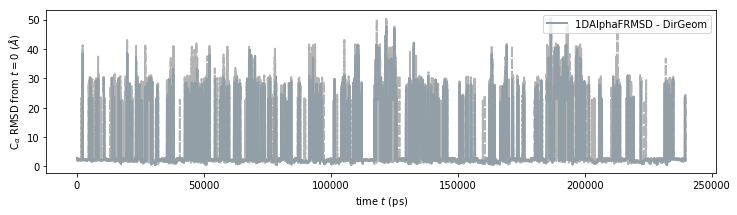

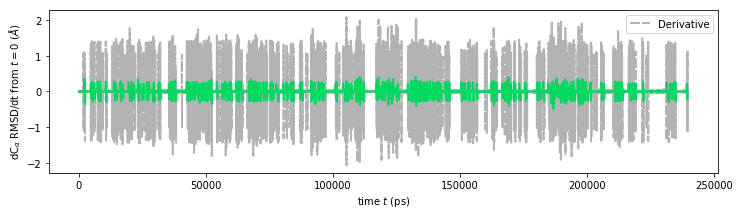

Processing hills file into array: 100% [000000000000] Time: 0:00:00 366.30 kB/s


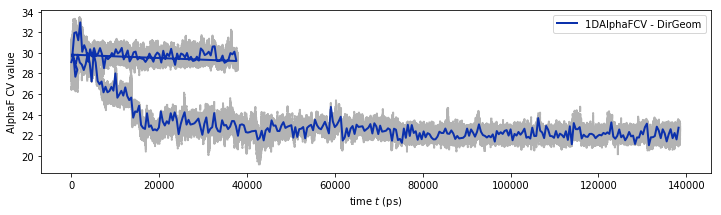

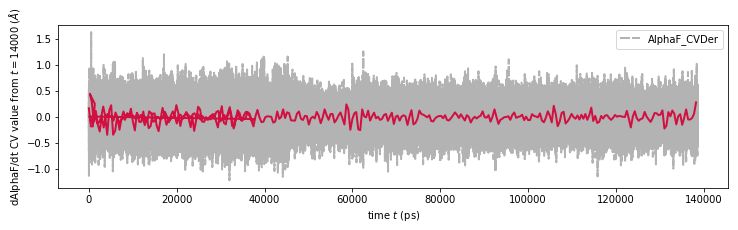

In [20]:
#Example run of RMSD and AlphaF CV plotting functions using GeomPol simulation trajectory

res_fin=rmsd_vs_time("/home/kam1m17/iridis5_scratch/Met-npt.gro", "/home/kam1m17/iridis5_scratch/Met_Folding_new.xtc", "/home/kam1m17/iridis5_scratch/init_met2c.pdb")

plot_rmsd_vs_time(res_fin, "1DAlphaFRMSD - DirGeom", (random.random(),random.random(),random.random()), "-", (0, (5, 1)), True, ncut=10)
#plot_rmsd_vs_time(res_fin, "1DAlphaFRMSD - GeomPol", (random.random(),random.random(),random.random()), True)

#Plotting evolution of "AlphaF" CV vs time for example simulation

AlphaFCV, AlphaF_DER=CVhills_vs_time("continue_intermediate/HILLS_GEOM_dir", True)

plot_cv_vs_time(AlphaFCV, "1DAlphaFCV - DirGeom", (random.random(),random.random(),random.random()), 
                True, AlphaF_DER, ncut=450)


In [24]:
#Visualing minimum RMSD stmin_rmsd.pdbe in loaded trajectory

view = nglview.show_file("min_rmsd.pdb")
#view.add_cartoon(selection="protein", color="blue")
view.add_licorice('TRP')
view.add_licorice('PRO')
view.add_ball_and_stick('protein')
view.center(selection='protein', duration=1)
view

A Jupyter Widget

In [23]:
clusters, vis, clusts, u_centroids, u_minimum = clustering("trp_ref.pdb", "trpgeompol_run1.dcd").affinity_propagation(preference=-8.0)

vis

KeyboardInterrupt: 

In [39]:
nframes = len(u_minimum.trajectory)

ref = mda.Universe("folded.pdb")

alignment = align.AlignTraj(u_minimum, ref, select='protein and name CA', in_memory=True, verbose=True)
alignment.run()

view = nglview.show_mdanalysis(u_minimum)
view.add_cartoon(selection="protein")
view.add_licorice('TRP')
view.add_licorice('PRO')
view.center(selection='protein', duration=nframes)
#view.player.parameters = dict(frame=True)

view

Step     4/4 [100.0%]


A Jupyter Widget

In [41]:
from nglview.contrib.movie import MovieMaker
movie = MovieMaker(vis, output='centroids_geommut.gif')
movie.make()


[MoviePy] Building file centroids_geommut.gif with imageio


 91%|█████████ | 10/11 [00:04<00:00,  2.29it/s]


In [54]:
#clusts #Note - get RMSD + AlphaFCV value (need to parse to PLUMED) to be able to plot RMSD vs AlphaFCV plot for cluster
       #centroids
    
res_centroids=rmsd_vs_time_MDanalysis(u_minimum, "folded.pdb")
#res_centroids[:,0] = clusts['Centroid Time (ps)']

protein = u_minimum.select_atoms("protein")
with mda.Writer("min_cluster.xtc", protein.n_atoms) as W:
    for ts in u_minimum.trajectory:
        W.write(protein)

#plot_rmsd_vs_time(res_centroids, "GeomPol - Centroids", (random.random(),random.random(),random.random()), (0, (1, 5)), (0, (1, 5)), ncut=1)
#plot_rmsd_vs_time(res_fin, "1DAlphaFRMSD - GeomPol", (random.random(),random.random(),random.random()), "-", (0, (5, 1)), ncut=10)

subprocess.Popen(["plumed driver --plumed alphaF.dat --mf_xtc min_cluster.xtc"], shell=True).wait()



exfile = open("Clusters", "r")
exlines = exfile.read().splitlines()

Hbondvals = []
alphavals = []
times = []
    
widgets = ['Processing hills file into array: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA(), ' ', FileTransferSpeed()] #see docs for other options

pbar = ProgressBar(widgets=widgets, maxval=len(exlines))
pbar.start()

for idx, line in enumerate(exlines):
       if line.split()[1] != "FIELDS" and line.split()[1] != "SET":
            Hbondvals.append(line.split()[2])
            alphavals.append(line.split()[1])
            times.append(line.split()[0])
       pbar.update(idx)
pbar.finish()
print        

AlphaFex = np.zeros((len(alphavals), 3), dtype=np.float64)
AlphaFex[:,0] = times
AlphaFex[:,1] = alphavals
AlphaFex[:,2] = Hbondvals

#Forming array with centroid frame times (in ps), RMSD, and AlphaF and Hbonds CV values

fullarray = np.zeros((len(res_centroids), 4), dtype=np.float64)

fullarray[:,0] = res_centroids[:,0]
fullarray[:,1] = res_centroids[:,1]
fullarray[:,2] = AlphaFex[:,1]
fullarray[:,3] = AlphaFex[:,2]

%matplotlib auto

fig2 = plt.figure(figsize=(18,9))
ax_cv = fig2.add_subplot(111, projection='3d')

cm = plt.cm.rainbow_r
sc = ax_cv.scatter3D(fullarray[:,3], fullarray[:,2], fullarray[:,1], marker="o", c=fullarray[:,0], alpha=1.0,
                   vmin=int(np.min(fullarray[:,0])), vmax=int(np.max(fullarray[:,0])),  cmap=cm,
                   label="HbondvsAlphaFvsRMSD - 1DGeomMut")
surf = ax_cv.plot_trisurf(fullarray[:,3], fullarray[:,2], fullarray[:,1], alpha=0.5, antialiased=True,
                   vmin=int(np.min(fullarray[:,0])), vmax=int(np.max(fullarray[:,0])), cmap=cm)
#wframe = ax_cv.plot_wireframe(fullarray[:,3], fullarray[:,2], FIXTHIS, alpha=0.5,cmap=cm)
ax_cv.legend(loc="best")
ax_cv.set_xlabel(r"Hbond CV value")
ax_cv.set_ylabel(r"AlphaF CV value")
ax_cv.set_zlabel(r"C$_\alpha$ RMSD ($\AA$)")
plt.colorbar(surf)
plt.show()
#fig = plt.figure(figsize=(12,6))
#ax_rmsd = fig.add_subplot(111, projection='3d')
#ax_rmsd.scatter3D(fullarray[:,1], fullarray[:,2], fullarray[:,0], color="red", label="RMSDvsAlphaF - 1DGeomPol")
#ax_rmsd.contour3D(fullarray[:,1], fullarray[:,2], fullarray[:,0], color="red", label="RMSDvsAlphaF - 1DGeomPol")
#ax_rmsd.legend(loc="best")
#ax_rmsd.set_xlabel(r"C$_\alpha$ RMSD ($\AA$)")
#ax_rmsd.set_ylabel(r"AlphaF CV value")
#ax_rmsd.set_zlabel(r"Time (ps)")
#plt.show()


Average RMSD value = 5.070567 Å
Minimum RMSD value at 0 ps = 4.792051 Å
Maximum RMSD value at 1 ps = 5.207620 Å



Calculating RMSD vs time: 100% [00000000000000000000] Time: 0:00:00   2.12 kB/s
Processing hills file into array: 100% [000000000000] Time: 0:00:00   5.83 kB/s


ValueError: could not broadcast input array from shape (10) into shape (4)


Average RMSD value = 3.258712 Å
Minimum RMSD value at 159500 ps = 1.722994 Å
Maximum RMSD value at 76780 ps = 9.105654 Å


Calculating RMSD vs time: 100% [00000000000000000000] Time: 0:00:05   3.02 kB/s


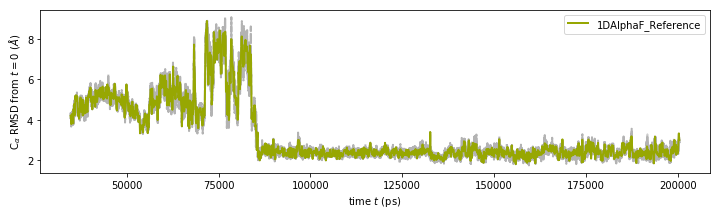

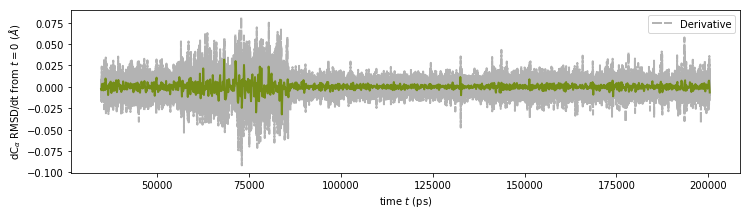

Processing hills file into array: 100% [000000000000] Time: 0:00:00 373.07 kB/s


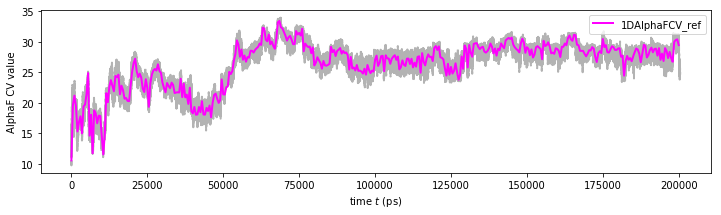

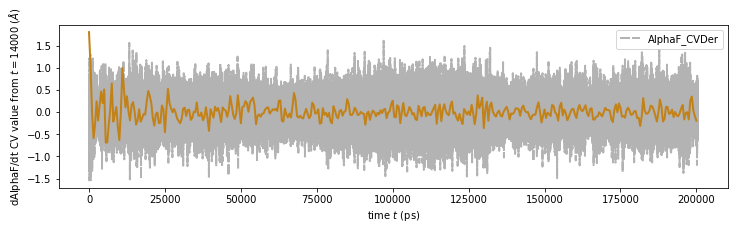

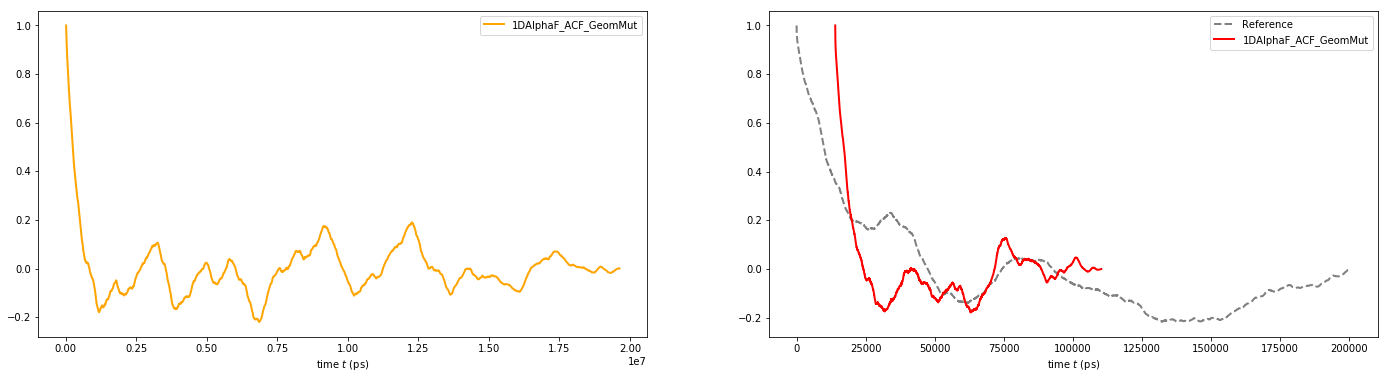

In [55]:
#Plotting RMSD vs time autocorrelation functions for the AMOEBA simulations

%matplotlib inline

res_fin[:,0] = [(res_fin[i,0]*1000 + 20000) for i in range(0, len(res_fin[:,0]))]

Ex_ACF = acf(res_fin[:,1], nlags=len(res_fin[:,0]))

EX_corr = np.zeros((len(Ex_ACF), 2), dtype=np.float64)
EX_corr[:,0] = res_fin[:,0]
EX_corr[:,1] = Ex_ACF

#Plotting AlphaFCV vs time autocorrelation functions for the AMOEBA simulations

AlphaF_ACF = acf(AlphaFCV[:,1], nlags=len(AlphaFCV[:,0]))

AlphaF_corr = np.zeros((len(AlphaF_ACF), 2), dtype=np.float64)
AlphaF_corr[:,0] = AlphaFCV[:,0]
AlphaF_corr[:,1] = AlphaF_ACF

#Compare with the current best 1DAlphaF MetaD simulation - in AMBERSB14

res_ref=rmsd_vs_time("folded.pdb", "1DalphaF_full.xtc", "folded.pdb")

plot_rmsd_vs_time(res_ref, "1DAlphaF_Reference", (random.random(),random.random(),random.random()),  "-", (0, (5,1)), True, ncut=10)

AlphaFCV_ref, AlphaFref_der=CVhills_vs_time("HILLS", True)
plot_cv_vs_time(AlphaFCV_ref, "1DAlphaFCV_ref", "magenta", True, AlphaFref_der)

#Ex_ACF = acf(res_ref[:,1], nlags=len(res_ref[:,0]))

#EX_ref = np.zeros((len(Ex_ACF), 2), dtype=np.float64)
#EX_ref[:,0] = res_ref[:,0]
#EX_ref[:,1] = Ex_ACF


AlphaF_ACF = acf(AlphaFCV_ref[:,1], nlags=len(AlphaFCV_ref[:,0]))

AlphaFref_corr = np.zeros((len(AlphaF_ACF), 2), dtype=np.float64)
AlphaFref_corr[:,0] = AlphaFCV_ref[:,0]
AlphaFref_corr[:,1] = AlphaF_ACF

#Plotting all autocorrelation functions

fig = plt.figure(figsize=(24,6))

ax0 = fig.add_subplot(121)

#ax0.plot(EX_ref[:,0], EX_ref[:,1], linestyle="--", color="grey", lw=2, label="Reference")
ax0.plot(EX_corr[:,0], EX_corr[:,1], linestyle="-", color="orange", lw=2, label="1DAlphaF_ACF_GeomPol")
ax0.legend(loc="upper right")
ax0.set_xlabel(r"time $t$ (ps)")
#ax0.set_ylabel(r"d2C$_\alpha$ RMSD/dt2 from $t=0$ ($\AA$)")

ax1 = fig.add_subplot(122)

ax1.plot(AlphaFref_corr[:,0], AlphaFref_corr[:,1], linestyle="--", color="grey", lw=2, label="Reference")
ax1.plot(AlphaF_corr[:,0], AlphaF_corr[:,1], linestyle="-", color="red", lw=2, label="1DAlphaF_ACF_GeomPol")
ax1.legend(loc="upper right")
ax1.set_xlabel(r"time $t$ (ps)")
#ax1.set_ylabel(r"d2C$_\alpha$ RMSD/dt2 from $t=0$ ($\AA$)")

plt.show()




In [ ]:
#Partial autocorrelation for final lags - observing decorrelation upon convergence

%matplotlib inline

plot_acf(res_ref[:,1], lags=len(res_ref[500:,0]))
plot_acf(res_fin[:,1], lags=len(res_fin[500:,0]))

AlphaFCV_ref, AlphaFref_der=CVhills_vs_time("HILLS", True)
plot_cv_vs_time(AlphaFCV_ref, "1DAlphaFCV_ref", "magenta", True, AlphaFref_der)

plot_acf(AlphaFCV_ref[:,1])

In [ ]:
#Plotting RMSD vs time graphs for all 6 AMOEBA simulations

if __name__ == "__main__":
    
    import subprocess
    
    dcdstd = subprocess.Popen(["ls -1 *.dcd"], shell=True, stdout=subprocess.PIPE).stdout
    dcdfiles = dcdstd.read().splitlines()
    
    hillstd = subprocess.Popen(["ls -1 HILLS_*"], shell=True, stdout=subprocess.PIPE).stdout
    hillfiles = hillstd.read().splitlines()
    
    labnames = ["1DAlphaF - DiffMut", "1DAlphaF - DiffDir", "1DAlphaF - DiffPol", "1DAlphaF - GeomMut", "1DAlphaF - GeomDir", "1DAlphaF - GeomPol"]
    
    for i in range(0, len(dcdfiles)):
        
        res_fin=rmsd_vs_time("trp_ref.pdb", dcdfiles[i], "folded.pdb")
        plot_rmsd_vs_time(res_fin, labnames[i], (random.random(),random.random(),random.random()), True)
        
        AlphaFCV, AlphaF_DER=CVhills_vs_time(hillfiles[i], True)
        plot_cv_vs_time(AlphaFCV, labnames[i], (random.random(),random.random(),random.random()), True, AlphaF_DER, ncut=450)

In [ ]:
exfile = open("HILLS_GEOM_pol", "r")
exlines = exfile.read().splitlines()

col = (random.random(),random.random(),random.random())

alphavals = []
times = []

for idx, line in enumerate(exlines):
       if line.split()[1] != "FIELDS" and line.split()[1] != "SET":
            alphavals.append(line.split()[1])
            times.append(line.split()[0])

AlphaFex = np.zeros((len(alphavals), 2), dtype=np.float64)
AlphaFex[:,0] = times
AlphaFex[:,1] = alphavals

return AlphaFex

AlphaF_der = np.zeros(AlphaFex.shape, dtype=np.float64)
dt = AlphaFex[1,0] - AlphaFex[0,0]
AlphaF_der[:,0] = AlphaFex[:,0]
AlphaF_der[:,1] = np.gradient(AlphaFex[:,1], dt)

resmask = np.ones(len(AlphaF_der[:,1]), dtype=bool)
threshold = 0.30*AlphaF_der[np.argmax(AlphaF_der[:,1]), 1]

for val in range(0, len(AlphaF_der[:,1])):
    if np.abs(AlphaF_der[val,1]) > threshold:
        resmask[val] = False
        

AlphaF_result1 = AlphaF_der[resmask,...]

fig = plt.figure(figsize=(12,12))
ax3 = fig.add_subplot(211)
    
ax3.plot(AlphaFex[:,0], AlphaFex[:,1], linestyle="-", color=col, lw=0.5,label="1DAlphaf_GeomPol")
ax3.legend(loc="upper right")
ax3.set_xlabel(r"time $t$ (ps)")
ax3.set_ylabel(r"AlphaF CV value from $t=14000$ ($\AA$)")

ax4 = fig.add_subplot(212)
col = (random.random(),random.random(),random.random())   
ax4.plot(AlphaF_der[:,0], AlphaF_der[:,1], linestyle=(0, (5,1)), color="#B3B3B3", lw=0.5,label="AlphaF_CVDer")
ax4.plot(AlphaF_result1[:,0], AlphaF_result1[:,1], linestyle="-", color=col, lw=1)
ax4.legend(loc="upper right")
ax4.set_xlabel(r"time $t$ (ps)")
ax4.set_ylabel(r"dAlphaF/dt CV value from $t=14000$ ($\AA$)")

plt.show()



In [ ]:
#Numerical differentiation of RMSD values over time - d(RMSD)/dt

res_der = np.zeros(res_fin.shape, dtype=np.float64)
res_2nd = np.zeros(res_fin.shape, dtype=np.float64)

dt = res_fin[0,0] - res_fin[1,0]
res_der[:,0] = res_fin[:,0]
res_der[:,1] = np.gradient(res_fin[:,1], dt)

dt = res_fin[0,0] - res_fin[1,0]
res_2nd[:,0] = res_fin[:,0]
res_2nd[:,1] = np.gradient(res_der[:,1], dt)

resmask = np.ones(len(res_2nd[:,1]), dtype=bool)

for val in range(0, len(res_2nd[:,1])):
    if np.abs(res_2nd[val,1]) > 0.006:
        resmask[val] = False
        
result1 = res_2nd[resmask,...]

resmask = np.ones(len(res_der[:,1]), dtype=bool)

for val in range(0, len(res_der[:,1])):
    if np.abs(res_der[val,1]) > 0.075:
        resmask[val] = False
        
result2 = res_der[resmask,...]
        
fig = plt.figure(figsize=(12,9))

ax0 = fig.add_subplot(313)

ax0.plot(res_2nd[:,0], res_2nd[:,1], linestyle=(0, (5,1)), color="#D3D3D3", lw=2, label="Test_RMSD2der")
ax0.plot(result1[:,0], result1[:,1], linestyle="-", color="orange", lw=2)
ax0.legend(loc="upper right")
ax0.set_xlabel(r"time $t$ (ps)")
ax0.set_ylabel(r"d2C$_\alpha$ RMSD/dt2 from $t=0$ ($\AA$)")

ax1 = fig.add_subplot(312)
    
ax1.plot(res_der[:,0], res_der[:,1], linestyle=(0, (5,1)), color="#D3D3D3", lw=2, label="Test_RMSDder")
ax1.plot(result2[:,0], result2[:,1], linestyle="-", color="magenta", lw=2)
ax1.legend(loc="upper right")

ax1.set_ylabel(r"dC$_\alpha$ RMSD/dt from $t=0$ ($\AA$)")

ax2 = fig.add_subplot(311)

ax2.plot(res_fin[:,0], res_fin[:,1], linestyle="-", color="brown", lw=2, label="Test_RMSDfin")
ax2.legend(loc="upper right")

ax2.set_ylabel(r"C$_\alpha$ RMSD from $t=0$ ($\AA$)")

plt.show()

